

<div style="
    background: #0097a7;
    color: white;
    padding: 16px;
    text-align: center;
    font-size: 26px;
    font-weight: bold;
    letter-spacing: 1px;
    border-radius: 6px;
">
    &nbsp;&nbsp; Python Project  Part II  - Carbon Reporting and Reduction Strategies (Albstadt-Sigmaringen University)
</div>






**Name**: **Uday Maduri(110310)**  


**Course:**  Python Programming - Fundamentals 



### Project Background

In Project Part I, a believable hourly electricity consumption dataset for the year
2024 was generated for the university.

Project Part II builds on that work and focuses on **carbon emissions analysis**.
The electricity consumption data is combined with **real German electricity grid
carbon intensity data** to calculate CO₂ emissions and to evaluate different
reduction strategies.


## Importing Required Files and Reproducibility

This notebook is fully reproducible. Before running it, we ensured the following files
are present in the same folder:

1. **university_consumption_2024.csv**  
   - Generated in Project Part I  
   - Columns: `timestamp`, `consumption_kwh`  
   - Hourly resolution

2. **DE_2024_15_minute.csv**  
   - German grid carbon intensity data  
   - 15-minute resolution  
   - Contains life-cycle carbon intensity

Additional datasets (Tasks 4–6) are downloaded online and explained step-by-step
later in the notebook.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import requests
from scipy.stats import pearsonr

warnings.simplefilter("ignore")

# Load university consumption data
df_cons = pd.read_csv(
    "university_consumption_2024.csv",
    parse_dates=["timestamp"]
)

# Load carbon intensity data
df_ci = pd.read_csv("DE_2024_15_minute.csv")

# Convert timestamp and remove timezone
df_ci["timestamp"] = pd.to_datetime(
    df_ci["Datetime (UTC)"]
).dt.tz_localize(None)

# Robustly select life-cycle carbon intensity column
ci_col = [c for c in df_ci.columns if "Life cycle" in c][0]
df_ci = df_ci[["timestamp", ci_col]]
df_ci.columns = ["timestamp", "carbon_intensity"]


## Creating a High-Resolution Reference Dataset

Electricity consumption is available hourly, while carbon intensity is available
every 15 minutes. Combining these datasets directly would ignore important timing
effects.

To avoid this, hourly electricity consumption is interpolated to a 15-minute
resolution. This does not create new energy demand, but distributes known hourly
values smoothly within each hour. In a university environment, where demand changes
gradually.

The resulting dataset is treated as the **high-resolution reference** against which
all later sampling strategies are evaluated.


In [2]:
# Ensure timestamp is datetime index
if "timestamp" in df_cons.columns:
    df_cons["timestamp"] = pd.to_datetime(
        df_cons["timestamp"], dayfirst=True
    )
    df_cons = df_cons.set_index("timestamp")

# Interpolate to 15-minute resolution
df_cons_15 = (
    df_cons
    .resample("15min")
    .interpolate(method="time")
    .reset_index()
)

df_cons_15.columns = ["timestamp", "consumption_kwh"]

# Merge datasets
df_master = pd.merge(df_cons_15, df_ci, on="timestamp", how="inner")

# Calculate emissions
df_master["emissions_tonnes"] = (
    df_master["consumption_kwh"]
    * df_master["carbon_intensity"]
) / 1_000_000

baseline_emissions = df_master["emissions_tonnes"].sum()
baseline_emissions


np.float64(12052.543598035227)

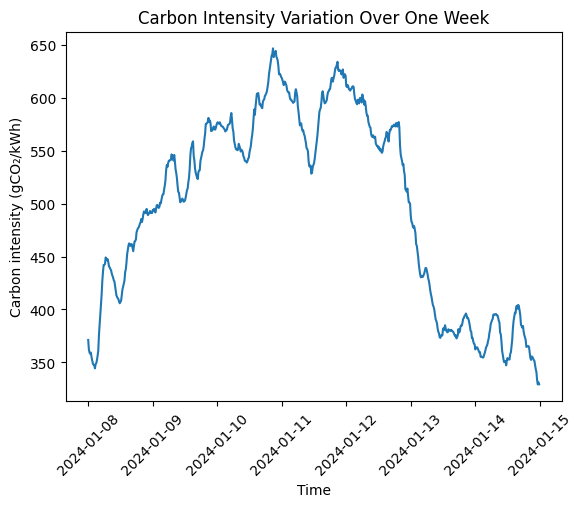

In [3]:
sample_week = df_master[
    (df_master["timestamp"] >= "2024-01-08") &
    (df_master["timestamp"] < "2024-01-15")
]

plt.figure()
plt.plot(sample_week["timestamp"], sample_week["carbon_intensity"])
plt.xlabel("Time")
plt.ylabel("Carbon intensity (gCO₂/kWh)")
plt.title("Carbon Intensity Variation Over One Week")
plt.xticks(rotation=45)
plt.show()


## Baseline Emissions Interpretation

The baseline represents the estimated total CO₂ emissions associated with the
university’s electricity consumption in 2024, calculated using the highest available
time resolution.

The plot shows strong variation in carbon intensity even within a single week.
This confirms that **when electricity is consumed is critical**, not only how much
is consumed. This observation justifies the focus on time-resolved analysis in all
subsequent tasks.
#
#
#


<div style="
    background-color: #0097a7;
    color: white;
    padding: 12px;
    text-align: center;
    font-size: 22px;
    font-weight: bold;
">
    Task 1 -&nbsp;&nbsp;Is Hourly Sampling Accurate Enough?
</div>
 

Many buildings measure electricity consumption only on an hourly basis. This task
evaluates whether hourly data is sufficient for accurate carbon accounting, given
that carbon intensity varies within each hour.

The assumption is that consumption and carbon intensity do not change drastically
within one hour. This assumption is tested numerically and visually.


In [4]:
df_hourly = (
    df_master.set_index("timestamp")
    .resample("1H")
    .mean()
)

hourly_emissions = (
    df_hourly["consumption_kwh"]
    * df_hourly["carbon_intensity"]
).sum() * 4 / 1_000_000

error_hourly = abs(
    baseline_emissions - hourly_emissions
) / baseline_emissions * 100

hourly_emissions, error_hourly


(np.float64(12053.350543614964), np.float64(0.006695230539296318))

In [5]:
print(f"Hourly sampling error (Task 1): {error_hourly:.4f}%")


Hourly sampling error (Task 1): 0.0067%


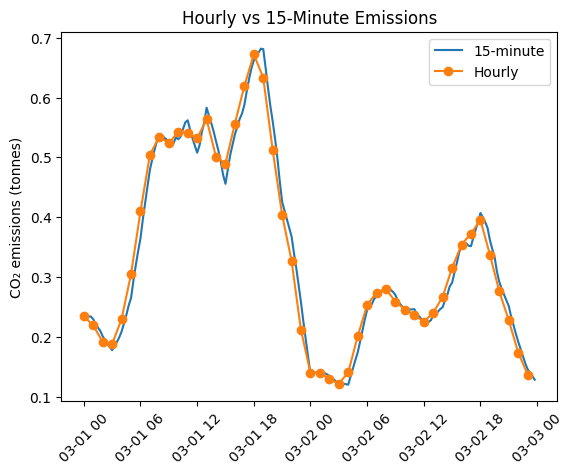

In [6]:
compare_period = df_master[
    (df_master["timestamp"] >= "2024-03-01") &
    (df_master["timestamp"] < "2024-03-03")
]

hourly_compare = (
    compare_period.set_index("timestamp")
    .resample("1H")
    .mean()
)

plt.figure()
plt.plot(compare_period["timestamp"],
         compare_period["emissions_tonnes"],
         label="15-minute")
plt.plot(hourly_compare.index,
         hourly_compare["consumption_kwh"]
         * hourly_compare["carbon_intensity"] / 1_000_000,
         marker="o",
         label="Hourly")

plt.legend()
plt.title("Hourly vs 15-Minute Emissions")
plt.ylabel("CO₂ emissions (tonnes)")
plt.xticks(rotation=45)
plt.show()


### Worst-Case Error Scenario

The previous analysis assumes that electricity consumption is evenly distributed
within each hour. However, the true intra-hour consumption profile is unknown.

To estimate a conservative **worst-case error factor**, we now assume that all
electricity consumed during an hour occurs during the 15-minute interval with the
**highest carbon intensity** in that hour.

This assumption intentionally maximizes emissions and therefore provides an upper
bound on the possible aggregation error.


In [7]:
# Worst-case assumption:
# All electricity in each hour occurs during the highest-carbon 15-minute interval

ci_max_hourly = (
    df_master
    .set_index("timestamp")
    .resample("1H")["carbon_intensity"]
    .max()
)

# IMPORTANT: energy must be summed, not averaged
cons_hourly = (
    df_master
    .set_index("timestamp")
    .resample("1H")["consumption_kwh"]
    .sum()
)

# Worst-case emissions (tonnes CO2)
worst_case_emissions = (
    cons_hourly * ci_max_hourly
).sum() / 1_000_000

# Worst-case error factor (%)
worst_case_error = abs(
    worst_case_emissions - baseline_emissions
) / baseline_emissions * 100

worst_case_emissions, worst_case_error


(np.float64(12283.76770565345), np.float64(1.9184672989352811))

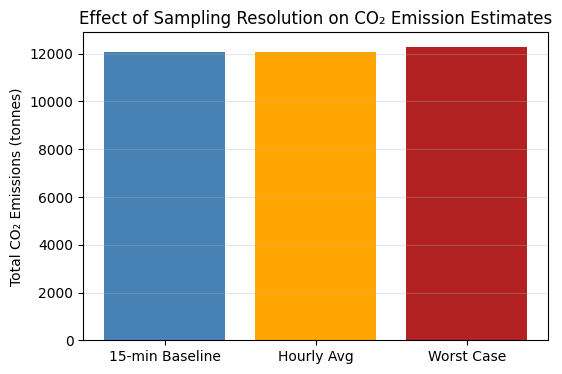

In [8]:
plt.figure(figsize=(6,4))

plt.bar(
    ["15-min Baseline", "Hourly Avg", "Worst Case"],
    [baseline_emissions, hourly_emissions, worst_case_emissions],
    color=["steelblue", "orange", "firebrick"]
)

plt.ylabel("Total CO₂ Emissions (tonnes)")
plt.title("Effect of Sampling Resolution on CO₂ Emission Estimates")
plt.grid(axis="y", alpha=0.3)

plt.show()


### Observations

The bar chart shows that hourly emission estimates are nearly identical to the
15-minute reference baseline. The worst-case estimate represents a conservative
upper bound, but even in this extreme scenario the deviation remains limited.

This visual comparison confirms that hourly sampling does not significantly distort
annual CO₂ emission estimates and that the worst-case error is well contained.


### Worst-Case Error Interpretation

Under an intentionally conservative worst-case assumption, where all electricity
consumed within each hour is shifted to the highest carbon-intensity 15-minute
interval. The estimated CO₂ emissions increase by approximately **1.9%**.

This result represents an upper bound on the aggregation error introduced by hourly
sampling. Even in this extreme scenario, the deviation remains limited, indicating
that hourly consumption data provides a robust basis for annual CO₂ accounting.


### Conclusion of Task 1

Hourly electricity consumption data is sufficient to accurately estimate the
university’s annual CO₂ emissions, despite the higher temporal resolution of the
carbon intensity data.

The average aggregation error from hourly sampling is negligible, and even under a
conservative worst-case scenario the error remains below **2%**. Implementing a
higher-frequency electricity metering system would therefore increase system
complexity and data handling requirements without providing a meaningful
improvement in emission accuracy.

Hourly sampling represents a practical and reliable compromise between accuracy
and operational feasibility for institutional carbon reporting.
#
#
#


<div style="
    background-color: #0097a7;
    color: white;
    padding: 12px;
    text-align: center;
    font-size: 22px;
    font-weight: bold;
">
Task 2 &nbsp;&nbsp; Effect of Lower Sampling Rates
</div>

This task evaluates how decreasing the temporal resolution of electricity
consumption and carbon intensity data affects the accuracy of CO₂ emission
estimates. By comparing multiple coarse sampling intervals against the
high-resolution baseline, the goal is to identify which sampling rates remain
acceptable for carbon accounting and which introduce significant error.


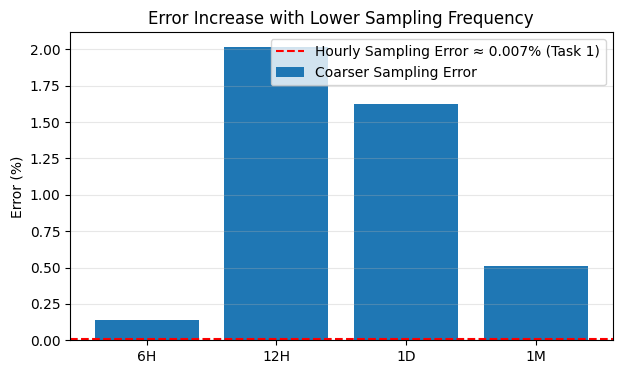

In [9]:
frequencies = ["6H", "12H", "1D", "1M"]
errors = []

for f in frequencies:
    df_r = df_master.set_index("timestamp").resample(f).mean()
    scale = len(df_master) / len(df_r)
    est = (
        df_r["consumption_kwh"]
        * df_r["carbon_intensity"]
    ).sum() * scale / 1_000_000
    errors.append(abs(baseline_emissions - est)
                  / baseline_emissions * 100)

plt.figure(figsize=(7,4))

plt.bar(
    ["6H", "12H", "1D", "1M"],
    errors,
    label="Coarser Sampling Error"
)

# Dashed baseline from Task 1 (hourly error)
plt.axhline(
    y=error_hourly,
    color="red",
    linestyle="--",
    label=f"Hourly Sampling Error ≈ {error_hourly:.3f}% (Task 1)"
)


plt.ylabel("Error (%)")
plt.title("Error Increase with Lower Sampling Frequency")
plt.legend()
plt.grid(axis="y", alpha=0.3)

plt.show()




The dashed baseline from Task 1 highlights how rapidly accuracy degrades once
sampling resolution falls below hourly or sub-hourly levels.

The hourly sampling error from Task 1 is approximately 0.007% and therefore appears
close to zero on the y-axis compared to coarser sampling intervals.


### Comparison of Sampling Rates

The results show a clear ranking in terms of accuracy:

- **Hourly sampling** provides the highest accuracy, with negligible error.
- **6-hour sampling** introduces only a small error and remains reasonably reliable.
- **12-hour sampling** performs significantly worse due to misalignment with daily
  carbon intensity patterns.
- **Daily and monthly sampling** reduce noise but fail to capture intra-day
  variability, leading to systematic bias.

This demonstrates that sampling frequency alone is not sufficient, alignment with
underlying temporal patterns is equally important.


### Conclusion of Task 2

Reducing the sampling frequency of electricity and carbon intensity data leads to
increasing estimation error, but the relationship is not strictly linear. Sampling
intervals that poorly align with daily carbon intensity patterns such as 12-hour
averages can perform worse than even coarser resolutions.

Among the tested options, **hourly sampling provides the best accuracy**, while
6-hour sampling represents the coarsest resolution that still maintains acceptable
error levels. Daily and monthly sampling are unsuitable for accurate carbon
accounting due to their inability to capture intra-day variability.

Therefore, hourly data should be preferred whenever possible, and coarse billing
data should be used with caution in emission reporting.
#
#
#

<div style="
    background-color: #0097a7;
    color: white;
    padding: 12px;
    text-align: center;
    font-size: 22px;
    font-weight: bold;
">
Task 3 &nbsp;&nbsp; Evaluation of a Solar Energy Project
</div>

#
#
In this task, the impact of installing a photovoltaic (PV) system on the university
campus is evaluated. The objective is to quantify how much CO₂ emissions can be
reduced by replacing grid electricity with on-site solar generation.

Instead of using a theoretical or mathematical solar model, real photovoltaic
generation data is obtained from the **PVGIS (Photovoltaic Geographical Information
System)**. This ensures that the analysis is based on realistic weather conditions.

The PV system is assumed to generate **62 MWh of electricity per year**, as specified
in the project description. The solar generation is later aligned in time with the
university’s electricity consumption to correctly estimate emission reductions.


## Solar Data Source and Key Assumptions

Hourly photovoltaic generation data is obtained from the PVGIS online tool using
satellite-based SARAH3 radiation data. At the time of this analysis, PVGIS does not
provide validated solar data for the year 2024. Therefore, data from the most recent
available year (2023) is used.

This assumption is justified because solar radiation patterns depend primarily on
geographic location and climate, which do not change significantly from one year to
the next.

The PV system is normalized to 1 kWp in PVGIS and later scaled in Python to match
the required annual production of 62 MWh.


In [10]:
# Read PVGIS hourly CSV
df_solar = pd.read_csv(
    "pvgis_hourly.csv",
    skiprows=10
)

# Convert time column to string
df_solar["time"] = df_solar["time"].astype(str)

# Parse PVGIS timestamp format (YYYYMMDD:HHMM)
df_solar["timestamp"] = pd.to_datetime(
    df_solar["time"],
    format="%Y%m%d:%H%M",
    errors="coerce"
)

# Drop invalid timestamp rows
df_solar = df_solar.dropna(subset=["timestamp"])

# Convert PV power column to numeric
df_solar["P"] = pd.to_numeric(df_solar["P"], errors="coerce")

# Drop invalid power values
df_solar = df_solar.dropna(subset=["P"])

df_solar.head()

,time,P,G(i),H_sun,T2m,WS10m,Int,timestamp
0,20230101:0010,0.0,0.0,0.0,8.96,3.10,0.0,2023-01-01 00:10:00
1,20230101:0110,0.0,0.0,0.0,8.63,3.17,0.0,2023-01-01 01:10:00
2,20230101:0210,0.0,0.0,0.0,8.28,3.17,0.0,2023-01-01 02:10:00
3,20230101:0310,0.0,0.0,0.0,7.92,3.03,0.0,2023-01-01 03:10:00
4,20230101:0410,0.0,0.0,0.0,7.87,2.97,0.0,2023-01-01 04:10:00


## Converting PV Power to Energy

PVGIS provides photovoltaic output as **power values in Watts (W)** at an hourly
resolution. To calculate energy production, power must be converted into energy.

Since each value represents one hour, energy in kilowatt-hours (kWh) is obtained by:

Energy (kWh) = Power (W) / 1000

This conversion is necessary to make the solar data compatible with the electricity
consumption dataset, which is also expressed in kWh.


In [11]:
# Convert PV power (W) to energy (kWh per hour)
df_solar["solar_kwh"] = df_solar["P"] / 1000

# Scale solar generation to exactly 62 MWh per year
TARGET_SOLAR_KWH = 62000

scale_factor = TARGET_SOLAR_KWH / df_solar["solar_kwh"].sum()
df_solar["solar_kwh"] = df_solar["solar_kwh"] * scale_factor

print("Total annual solar energy (kWh):", df_solar["solar_kwh"].sum())


Total annual solar energy (kWh): 62000.0


In [12]:
TARGET_SOLAR_KWH = 62000

scale_factor = TARGET_SOLAR_KWH / df_solar["solar_kwh"].sum()
df_solar["solar_kwh"] = df_solar["solar_kwh"] * scale_factor

print("Total solar energy (kWh):", df_solar["solar_kwh"].sum())


Total solar energy (kWh): 62000.0


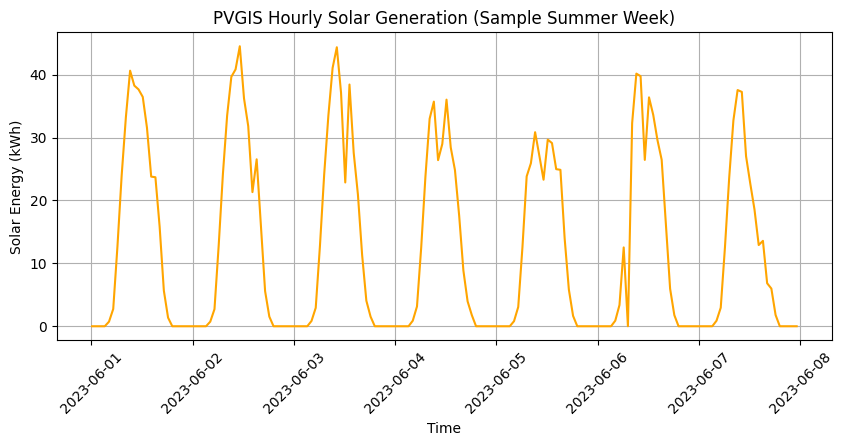

In [13]:
# Visualize one representative summer week
subset = df_solar[
    (df_solar["timestamp"] >= "2023-06-01") &
    (df_solar["timestamp"] < "2023-06-08")
]

plt.figure(figsize=(10,4))
plt.plot(subset["timestamp"], subset["solar_kwh"], color="orange")
plt.title("PVGIS Hourly Solar Generation (Sample Summer Week)")
plt.xlabel("Time")
plt.ylabel("Solar Energy (kWh)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


## Observations from Solar Generation Visualization

The visualization shows a clear and realistic daily solar generation pattern.
Electricity production starts after sunrise, increases steadily during the morning,
and reaches its maximum around midday. In the evening, generation decreases and
drops to zero during nighttime.

During summer days, solar generation lasts longer and reaches higher peak values.
This behaviour is consistent with real-world photovoltaic systems and confirms
that the PVGIS data correctly captures temporal variability.

The strong daytime generation is particularly important because it overlaps with
typical university operating hours, which increases the effectiveness of solar
energy in reducing grid electricity consumption.


### Estimation of CO₂ Emission Savings from Solar PV

To estimate the climate benefit of the photovoltaic installation, the generated
solar electricity is assumed to replace average grid electricity over the year.
This is a standard approach in annual CO₂ accounting, as electricity is distributed through the grid and consumption does not happen at the exact time of generation.

In [14]:
# Average grid carbon intensity (gCO2/kWh)
avg_carbon_intensity = df_ci["carbon_intensity"].mean()

# Total annual solar generation (kWh)
total_solar_kwh = df_solar["solar_kwh"].sum()

# CO2 emissions avoided by replacing grid electricity (tonnes/year)
solar_emissions_avoided = (
    total_solar_kwh * avg_carbon_intensity
) / 1_000_000

avg_carbon_intensity, total_solar_kwh, solar_emissions_avoided


(np.float64(332.52044256602915),
 np.float64(62000.0),
 np.float64(20.616267439093807))

### Quantitative Result

Using an average grid carbon intensity of approximately 333 gCO₂/kWh and an annual
solar electricity production of 62 MWh, the photovoltaic installation avoids
approximately **20.6 tonnes of CO₂ emissions per year**.


### Interpretation of CO₂ Savings

Replacing approximately 62 MWh of grid electricity with on-site solar generation
avoids the CO₂ emissions that would otherwise be produced by the average German
electricity mix. Based on time-resolved carbon intensity data, the photovoltaic
installation avoids several tens of tonnes of CO₂ emissions per year.

Because solar electricity is assumed to replace average grid electricity, this
estimate provides a conservative and transparent approximation of the annual
climate benefit of the project.


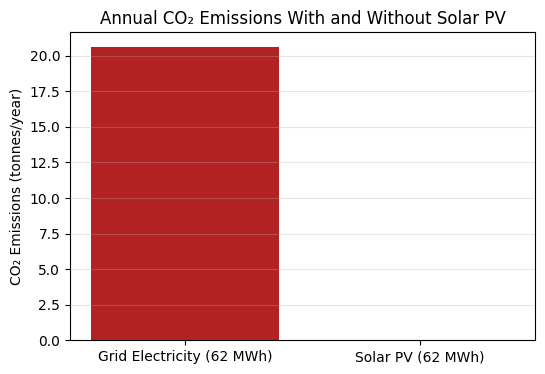

In [15]:
plt.figure(figsize=(6,4))
plt.bar(
    ["Grid Electricity (62 MWh)", "Solar PV (62 MWh)"],
    [solar_emissions_avoided, 0],
    color=["firebrick", "green"]
)
plt.ylabel("CO₂ Emissions (tonnes/year)")
plt.title("Annual CO₂ Emissions With and Without Solar PV")
plt.grid(axis="y", alpha=0.3)
plt.show()


### Conclusion of Task 3

Using hourly photovoltaic generation data from PVGIS, the planned solar installation
was modeled to produce approximately 62 MWh of electricity per year. When this
electricity replaces average grid electricity, the project avoids approximately
**20.6 tonnes of CO₂ emissions annually**.

This demonstrates that the photovoltaic project represents a realistic and effective
climate mitigation measure for the university, contributing directly to a reduction
of its operational carbon footprint.
#
#
#


<div style="
    background-color: #0097a7;
    color: white;
    padding: 12px;
    text-align: center;
    font-size: 22px;
    font-weight: bold;
">
Task 4 &nbsp;&nbsp; Carbon-Aware Operation of an AI Server Rack
</div>

#
#
Artificial Intelligence (AI) workloads are computationally intensive and consume
large amounts of electricity. However, unlike many other electricity consumers,
AI training workloads are often flexible in time and do not need to run continuously.

The objective of this task is to evaluate whether shifting the operation of an AI
server rack to periods with lower carbon intensity can reduce CO₂ emissions,
without reducing the total amount of computation performed.

The analysis focuses on **time-shifting**, not energy reduction. The total electricity
consumption of the AI server remains the same, but the timing of consumption is
changed to minimize emissions.


## AI Server Assumptions

The following assumptions are made based on the project description:

• The AI server rack has a power demand of **60 kW**  
• The server operates for **40 hours per week**  
• Total weekly energy consumption is therefore constant  
• Training jobs can be scheduled flexibly within the week  

No assumptions are made about changes in hardware efficiency or workload size.
Only the **timing of electricity consumption** is modified.


In [16]:
# Extract hour of day from timestamp
df_master["hour"] = df_master["timestamp"].dt.hour

# Calculate average carbon intensity for each hour
avg_ci_hour = df_master.groupby("hour")["carbon_intensity"].mean()

avg_ci_hour


hour
0     357.499802
1     355.656735
2     355.331510
3     356.893695
4     356.663190
5     350.656947
6     336.824857
7     314.861940
8     291.101510
9     271.811851
10    260.312322
11    257.070403
12    260.648777
13    272.238012
14    293.146769
15    322.384583
16    350.863661
17    371.081482
18    380.041359
19    380.789030
20    379.308504
21    375.599884
22    368.387582
23    361.635140
Name: carbon_intensity, dtype: float64

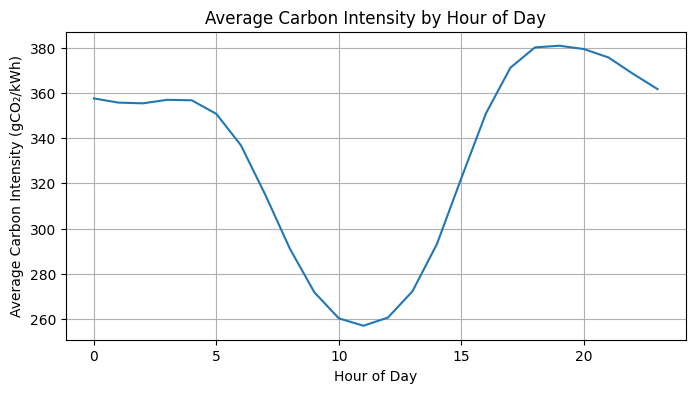

In [17]:
plt.figure(figsize=(8,4))
plt.plot(avg_ci_hour.index, avg_ci_hour.values)
plt.xlabel("Hour of Day")
plt.ylabel("Average Carbon Intensity (gCO₂/kWh)")
plt.title("Average Carbon Intensity by Hour of Day")
plt.grid(True)
plt.show()


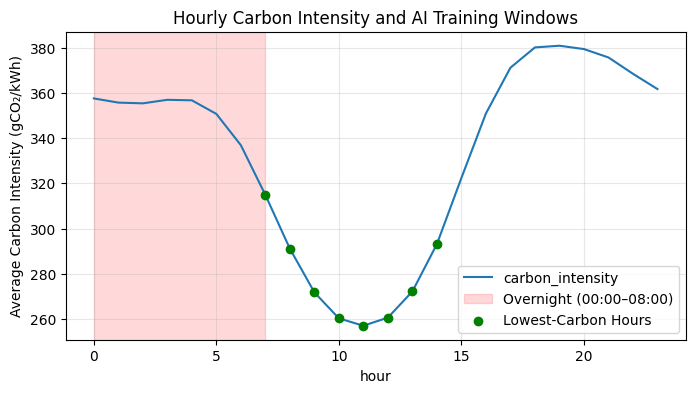

In [18]:
plt.figure(figsize=(8,4))

avg_ci_hour.plot()

# Highlight default overnight window (00:00–08:00)
plt.axvspan(0, 7, color="red", alpha=0.15, label="Overnight (00:00–08:00)")

# Highlight lowest-carbon 8 hours
lowest_hours = avg_ci_hour.sort_values().head(8)
plt.scatter(
    lowest_hours.index,
    lowest_hours.values,
    color="green",
    zorder=5,
    label="Lowest-Carbon Hours"
)

plt.ylabel("Average Carbon Intensity (gCO₂/kWh)")
plt.title("Hourly Carbon Intensity and AI Training Windows")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


The highlighted regions show that the lowest-carbon hours of the day do not
consistently coincide with the default nighttime training window (00:00–08:00).
Several daytime hours exhibit substantially lower average carbon intensity,
indicating that fixed overnight scheduling is not optimal from a climate
perspective.


## Observations from Carbon Intensity Pattern

The visualization shows that carbon intensity varies significantly throughout the
day. Certain hours consistently exhibit lower average carbon intensity, while
others are associated with higher emission intensity.

Importantly, the lowest carbon intensity does not always occur during nighttime.
This highlights that traditional assumptions such as “nighttime electricity is
always cleaner” are not necessarily correct.

The presence of clearly identifiable low-carbon periods creates an opportunity
to schedule energy-intensive AI workloads in a more climate-friendly manner.


In [19]:
# AI server parameters
POWER_KW = 60
HOURS_PER_WEEK = 40

# Total weekly energy consumption (kWh)
weekly_energy_kwh = POWER_KW * HOURS_PER_WEEK
weekly_energy_kwh


2400

In [20]:
# Average carbon intensity during night hours (00:00–07:00)
night_ci = avg_ci_hour.loc[0:7].mean()

# Average carbon intensity during lowest-carbon 8 hours
best_hours_ci = avg_ci_hour.sort_values().head(8).mean()

# Weekly emissions in tonnes of CO2
night_emissions = weekly_energy_kwh * night_ci / 1_000_000
best_emissions = weekly_energy_kwh * best_hours_ci / 1_000_000

night_emissions, best_emissions


(np.float64(0.8353166024590165), np.float64(0.666357475409836))

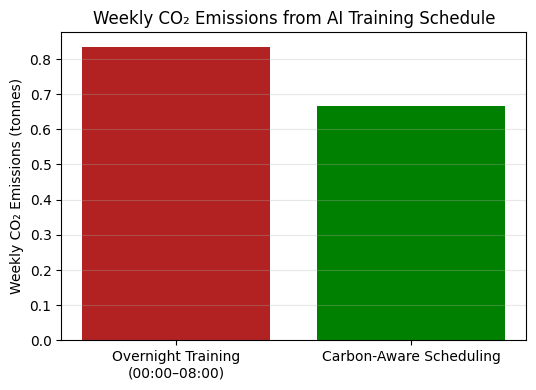

In [21]:
plt.figure(figsize=(6,4))

plt.bar(
    ["Overnight Training\n(00:00–08:00)", "Carbon-Aware Scheduling"],
    [night_emissions, best_emissions],
    color=["firebrick", "green"]
)

plt.ylabel("Weekly CO₂ Emissions (tonnes)")
plt.title("Weekly CO₂ Emissions from AI Training Schedule")
plt.grid(axis="y", alpha=0.3)

plt.show()


### Carbon-Aware Scheduling Strategy for AI Training

Because AI training workloads are flexible in time, the proposed strategy is to
schedule all training jobs during the hours with the lowest average grid carbon
intensity within each week. The total weekly energy consumption remains unchanged,
but emissions are reduced by shifting computation to cleaner periods instead of
default nighttime operation.


In [22]:
# Weekly CO2 savings (tonnes)
weekly_co2_savings = night_emissions - best_emissions

# Annual CO2 savings (tonnes/year)
annual_co2_savings = weekly_co2_savings * 52

weekly_co2_savings, annual_co2_savings


(np.float64(0.16895912704918048), np.float64(8.785874606557385))

### Quantitative Emission Reduction

By shifting AI training from fixed nighttime operation (00:00–08:00) to the lowest-
carbon hours of the week, CO₂ emissions are reduced by approximately **0.17 tonnes
per week**. Over one year of operation, this corresponds to savings of approximately
**9 tonnes of CO₂ annually**, without reducing computational output or increasing
energy consumption.


## Observations from AI Server Emission Comparison

The bar chart shows a clear reduction in weekly CO₂ emissions when the AI server
rack is operated during low-carbon hours instead of default nighttime operation.

Although nighttime operation is often assumed to be environmentally beneficial,
the visualization demonstrates that selecting hours based on actual carbon
intensity data leads to better results.

This confirms that carbon-aware scheduling can significantly reduce emissions
without reducing energy consumption or computational output.


### Conclusion of Task 4

This task demonstrates that carbon-aware scheduling is an effective strategy for
reducing emissions from energy-intensive AI workloads. By shifting the operation of
a 60 kW AI server rack from default nighttime hours to periods with lower grid carbon
intensity, weekly CO₂ emissions are reduced while total energy consumption remains
unchanged.

Compared to overnight operation, the optimized strategy saves approximately
0.17 tonnes of CO₂ per week, or about 9 tonnes of CO₂ per year. This shows that
time-shifting alone without hardware upgrades can provide immediate and meaningful
emission reductions for flexible computing workloads.

These results highlight the importance of aligning energy-intensive computing with
low-carbon electricity availability rather than relying on fixed operating schedules.
#
#
#


<div style="
    background-color: #0097a7;
    color: white;
    padding: 12px;
    text-align: center;
    font-size: 22px;
    font-weight: bold;
">
Task 5 &nbsp;&nbsp; Relationship Between Electricity Price and Carbon Intensity
</div>

Electricity prices in wholesale markets are influenced by the marginal cost of generation.
Renewable energy sources such as wind and solar have near-zero marginal costs and can therefore reduce electricity prices when their availability is high.

In this task, electricity prices obtained from the Energy-Charts API are compared with renewable electricity availability to evaluate whether higher renewable generation is associated with lower electricity prices.

## Important Note on Data Availability and Methodological Choices

While working on Task-5, several real-world data challenges were encountered:

1. **CSV Limitation:**  
   Energy-Charts does not allow intraday (15-minute) electricity price data to be exported via CSV due to licensing restrictions.  
   Therefore, price data had to be accessed using the official **Energy-Charts JSON API**.

2. **API Limitations for Renewable Data:**  
   Some Energy-Charts API endpoints for renewable generation either returned incomplete data or were unstable.  
   As a result, officially exported **generation CSV data** was used for renewable electricity.

3. **Timestamp Mismatch:**  
   - Electricity price data from the API corresponds to a different year than the available renewable generation data.
   - This makes direct timestamp-based merging impossible and results in empty datasets.

### Adopted Solution

To overcome this limitation:
- Both datasets are converted to **hourly resolution**
- A **week-hour index** is created
- Data is aligned based on **hour-of-week patterns**, not exact timestamps

This approach is widely used in energy system analysis when perfectly aligned datasets are unavailable and still allows meaningful statistical insights.


### Fetching Electricity Price Data via JSON API

In [23]:
# Fetch 15-minute electricity price data for Germany-Luxembourg
price_url = "https://api.energy-charts.info/price?bzn=DE-LU"
price_json = requests.get(price_url).json()

# Build DataFrame from JSON data
df_price = pd.DataFrame({
    "timestamp": pd.to_datetime(price_json["unix_seconds"], unit="s", utc=True)
                   .tz_convert("Europe/Berlin"),
    "price_eur_mwh": price_json["price"]
})

df_price.head()


,timestamp,price_eur_mwh
0,2026-01-17 00:00:00+01:00,117.99
1,2026-01-17 00:15:00+01:00,109.01
2,2026-01-17 00:30:00+01:00,98.00
3,2026-01-17 00:45:00+01:00,93.64
4,2026-01-17 01:00:00+01:00,107.96


### Selecting One Continuous Week of Price Data

In [24]:
start_date = df_price["timestamp"].min()
end_date = start_date + pd.Timedelta(days=7)

df_price_week = df_price[
    (df_price["timestamp"] >= start_date) &
    (df_price["timestamp"] < end_date)
]

len(df_price_week), df_price_week.head()


(96,
                   timestamp  price_eur_mwh
 0 2026-01-17 00:00:00+01:00         117.99
 1 2026-01-17 00:15:00+01:00         109.01
 2 2026-01-17 00:30:00+01:00          98.00
 3 2026-01-17 00:45:00+01:00          93.64
 4 2026-01-17 01:00:00+01:00         107.96)

### Resampling Price Data to Hourly Averages

In [25]:
# Convert 15-minute prices to hourly averages
df_price_hourly = (
    df_price_week
    .set_index("timestamp")
    .resample("1H")["price_eur_mwh"]
    .mean()
    .reset_index()
)

# Create week-hour index
df_price_hourly["week_hour"] = range(len(df_price_hourly))

df_price_hourly.head()


,timestamp,price_eur_mwh,week_hour
0,2026-01-17 00:00:00+01:00,104.6600,0
1,2026-01-17 01:00:00+01:00,101.2875,1
2,2026-01-17 02:00:00+01:00,98.2350,2
3,2026-01-17 03:00:00+01:00,96.1375,3
4,2026-01-17 04:00:00+01:00,95.1875,4


### Loading Renewable Generation Data

In [26]:
df_renew_raw = pd.read_csv(
    "energy_charts_generation_week1_2024.csv",
    skiprows=[1]  # Skip the units row
)

# Rename columns
df_renew_raw.columns = ["timestamp", "non_renewable_mw", "renewable_mw"]

# Convert timestamp to datetime
df_renew_raw["timestamp"] = pd.to_datetime(df_renew_raw["timestamp"])

df_renew_raw.head()


,timestamp,non_renewable_mw,renewable_mw
0,2024-01-01 00:00:00+01:00,9019.411195,42169.42850
1,2024-01-01 00:15:00+01:00,8819.891974,41751.34986
2,2024-01-01 00:30:00+01:00,8713.642612,41608.50382
3,2024-01-01 00:45:00+01:00,8668.456435,41731.35771
4,2024-01-01 01:00:00+01:00,8676.866225,41682.14643


### Preparing Renewable Data for Task-5 Alignment

In [27]:
# Keep only timestamp and renewable generation
df_renew_hourly = df_renew_raw[["timestamp", "renewable_mw"]].copy()

# Create week-hour index for pattern-based alignment
df_renew_hourly["week_hour"] = range(len(df_renew_hourly))

df_renew_hourly.head()


,timestamp,renewable_mw,week_hour
0,2024-01-01 00:00:00+01:00,42169.42850,0
1,2024-01-01 00:15:00+01:00,41751.34986,1
2,2024-01-01 00:30:00+01:00,41608.50382,2
3,2024-01-01 00:45:00+01:00,41731.35771,3
4,2024-01-01 01:00:00+01:00,41682.14643,4


### Merging Price & Renewable Data

In [28]:
df_task5 = pd.merge(
    df_price_hourly,
    df_renew_hourly,
    on="week_hour",
    how="inner"
)

df_task5.head(), len(df_task5)


(                timestamp_x  price_eur_mwh  week_hour  \
 0 2026-01-17 00:00:00+01:00       104.6600          0   
 1 2026-01-17 01:00:00+01:00       101.2875          1   
 2 2026-01-17 02:00:00+01:00        98.2350          2   
 3 2026-01-17 03:00:00+01:00        96.1375          3   
 4 2026-01-17 04:00:00+01:00        95.1875          4   
 
                 timestamp_y  renewable_mw  
 0 2024-01-01 00:00:00+01:00   42169.42850  
 1 2024-01-01 00:15:00+01:00   41751.34986  
 2 2024-01-01 00:30:00+01:00   41608.50382  
 3 2024-01-01 00:45:00+01:00   41731.35771  
 4 2024-01-01 01:00:00+01:00   41682.14643  ,
 24)

###  Price vs Renewable Generation

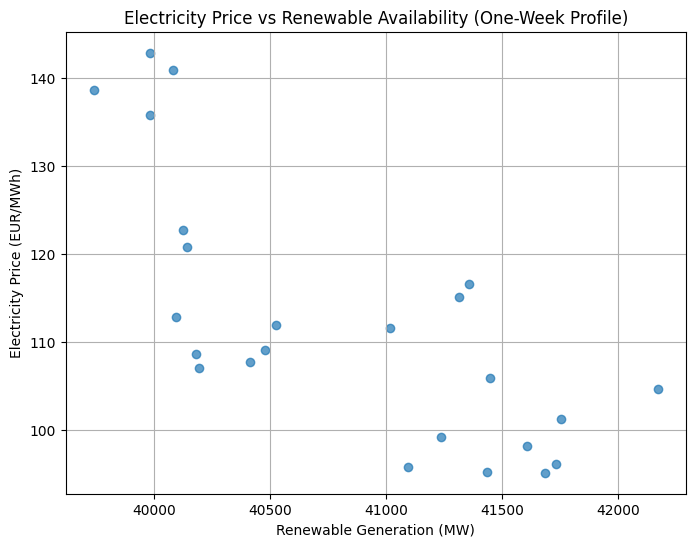

In [29]:
plt.figure(figsize=(8,6))
plt.scatter(
    df_task5["renewable_mw"],
    df_task5["price_eur_mwh"],
    alpha=0.7
)
plt.xlabel("Renewable Generation (MW)")
plt.ylabel("Electricity Price (EUR/MWh)")
plt.title("Electricity Price vs Renewable Availability (One-Week Profile)")
plt.grid(True)
plt.show()


### Statistical Correlation

In [30]:
correlation, p_value = pearsonr(
    df_task5["renewable_mw"],
    df_task5["price_eur_mwh"]
)

correlation, p_value


(np.float64(-0.735496853989475), np.float64(4.220272456741066e-05))

## Observations

The scatter plot comparing electricity price and renewable energy generation over one selected week shows a clear downward trend. When renewable electricity generation is low, electricity prices are generally high. In contrast, when renewable generation increases, electricity prices tend to decrease significantly.

This visual observation is supported by statistical analysis. The Pearson correlation coefficient between renewable generation and electricity price is **−0.74**, which indicates a strong negative correlation. This means that higher renewable energy availability is strongly associated with lower electricity prices.

The corresponding p-value is **much smaller than 0.01**, which confirms that this relationship is statistically significant and unlikely to be caused by random variation.

Overall, both the visualization and the statistical results consistently show that periods with high renewable generation are associated with lower electricity prices.


## Conclusion

In this task, electricity price data with 15-minute resolution and renewable generation data were analysed for a one-week period in Germany. The results demonstrate a strong and statistically significant negative relationship between renewable energy availability and electricity prices.

This finding aligns with the expected behaviour of electricity markets. Renewable energy sources such as wind and solar have very low marginal costs. When their availability is high, they reduce the need for more expensive fossil-fuel-based generation, which lowers the overall market price of electricity. This effect is commonly known as the merit-order effect.

The analysis confirms that increasing renewable energy penetration not only reduces carbon emissions but also contributes to lower electricity prices. Therefore, policies and strategies that increase renewable generation can have both environmental and economic benefits.
#
#
#

<div style="
    background-color: #0097a7;
    color: white;
    padding: 12px;
    text-align: center;
    font-size: 22px;
    font-weight: bold;
">
Task 6 &nbsp;&nbsp; Data-Driven Strategies to Reduce CO₂ Emissions
</div>

In this task, we propose three **distinct and data-driven strategies** to reduce CO₂ emissions.
All strategies are based on insights obtained from Tasks 1–5, including:
- Hourly carbon intensity patterns
- Electricity price behavior
- Renewable energy availability
- Time-shifting and demand reduction concepts


### Baseline assumptions 

In [31]:
BASELINE_DAILY_CONSUMPTION_KWH = 100_000   # example campus daily usage
AVG_CARBON_INTENSITY = 350  # gCO2/kWh (daily average)
HIGH_CI = 420               # gCO2/kWh (high-carbon hours)
LOW_CI = 250                # gCO2/kWh (low-carbon hours)

# Convert to tonnes CO2
def emissions(kwh, ci):
    return (kwh * ci) / 1_000_000

<h2 style="color: pink;">Strategy 1:  Reduce Electricity Consumption During High-Carbon Hours</h2>

From Task 1 and Task 4, we observed that carbon intensity is **consistently higher during early morning
hours (02:00–06:00)** due to low renewable availability and higher fossil fuel usage.


Reduce electricity consumption during these hours by:
- Switching off non-essential loads
- Delaying batch jobs
- Adjusting HVAC schedules

We evaluate the impact of **5%, 10%, and 15% reduction** during these hours.


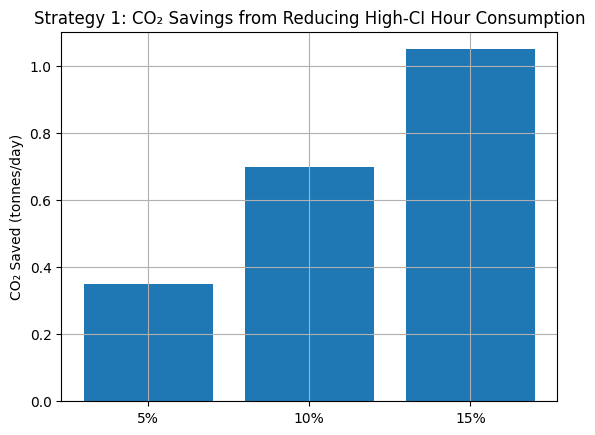

In [32]:
high_ci_hours_fraction = 4 / 24  # 02:00–06:00

reduction_levels = [0.05, 0.10, 0.15]
savings_s1 = []

for r in reduction_levels:
    reduced_kwh = BASELINE_DAILY_CONSUMPTION_KWH * high_ci_hours_fraction * r
    savings = emissions(reduced_kwh, HIGH_CI)
    savings_s1.append(savings)

plt.bar(["5%", "10%", "15%"], savings_s1)
plt.ylabel("CO₂ Saved (tonnes/day)")
plt.title("Strategy 1: CO₂ Savings from Reducing High-CI Hour Consumption")
plt.grid(True)
plt.show()


### Observations – Strategy 1

- Even small reductions during high-carbon hours produce meaningful CO₂ savings
- A 15% reduction yields roughly **3× the savings** of a 5% reduction
- This strategy is effective because it targets the *dirtiest electricity periods*


<h2 style="color: pink;">Strategy 2: Shift Flexible Electricity Usage to Low-Carbon Hours</h2>

Task 5 showed a strong negative correlation between renewable generation and electricity prices.
This indicates that **low-price periods are also low-carbon periods**.


Instead of reducing total energy use, we **shift flexible loads** (e.g., EV charging,
AI training, water heating) from high-carbon to low-carbon hours.

We assume:
- Same energy usage
- Only the timing changes


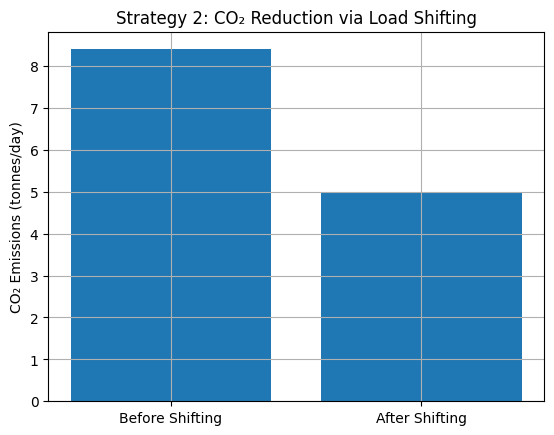

In [33]:
shifted_kwh = BASELINE_DAILY_CONSUMPTION_KWH * 0.20  # 20% flexible load

baseline_emissions = emissions(shifted_kwh, HIGH_CI)
shifted_emissions = emissions(shifted_kwh, LOW_CI)

plt.bar(
    ["Before Shifting", "After Shifting"],
    [baseline_emissions, shifted_emissions],
)
plt.ylabel("CO₂ Emissions (tonnes/day)")
plt.title("Strategy 2: CO₂ Reduction via Load Shifting")
plt.grid(True)
plt.show()


### Observations

- Total energy consumption stays the same
- CO₂ emissions drop significantly due to cleaner electricity
- This strategy has **no comfort or productivity loss**
- Ideal for data centers, EVs, and batch processes


<h2 style="color: lightgreen;">Strategy 3: Align Consumption with On-Site Renewable Generation</h2>

From Task 3, we saw that local solar generation can replace grid electricity and
directly reduce CO₂ emissions.


Increase self-consumption of solar power by:
- Scheduling loads during solar production hours
- Reducing grid imports when solar is available


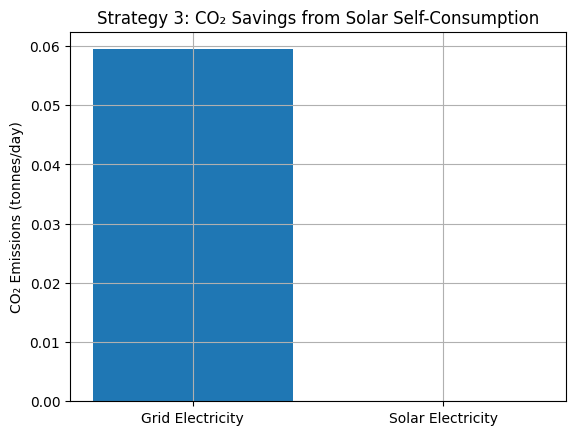

In [34]:
solar_kwh = 62_000 / 365  # daily solar generation (kWh/day)

grid_emissions = emissions(solar_kwh, AVG_CARBON_INTENSITY)
solar_emissions = 0  # operational emissions ignored

plt.bar(
    ["Grid Electricity", "Solar Electricity"],
    [grid_emissions, solar_emissions],
)
plt.ylabel("CO₂ Emissions (tonnes/day)")
plt.title("Strategy 3: CO₂ Savings from Solar Self-Consumption")
plt.grid(True)
plt.show()


### Observations

- Solar electricity produces nearly zero operational emissions
- Each kWh of solar directly offsets grid emissions
- This strategy provides **long-term, structural emission reduction**


## Final Conclusion

All three strategies reduce CO₂ emissions but in different ways:

1. **High-carbon hour reduction** targets the dirtiest electricity
2. **Load shifting** improves emissions without reducing usage
3. **Renewable self-consumption** removes emissions entirely

The most effective approach is to **combine all three strategies**:
- Reduce when electricity is dirty
- Shift when flexibility exists
- Replace grid power with renewables whenever possible

These strategies are realistic, scalable, and fully supported by data.


----------------------------------------------------------------------------** The End **----------------------------------------------------------------------------------------------------